In [1]:
# Librerias necesarias
import numpy as np
import pandas as pd
import matplotlib.pylab as pt
from sklearn import metrics
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn import svm
%matplotlib inline

In [2]:
# Toma un conjunto de datos y lo separa en conjunto de datos positivos y conjunto de datos negtivos
def split_positive_negative(dataframe):
    positive_df = dataframe[dataframe['Dx:Cancer'] == 1]
    negative_df = dataframe[dataframe['Dx:Cancer'] == 0]
    return positive_df, negative_df

# Toma un conjunto de datos y lo separa en x (variable cancer) e y (resto de variables), y lo convierte a np.array
def split_xy(dataframe):
    df_x = dataframe.copy()
    df_x.pop("Dx:Cancer")
    y = dataframe["Dx:Cancer"].to_numpy()
    x = df_x.to_numpy()
    return x, y

In [3]:
def evaluar_todo_el_set_de_datos(algorithm, dataframe, validation_split, metric):
    # Separamos el conjunto entre x e y
    x, y = split_xy(dataframe)
    # Dividimos entre conjunto de entrenamiento y conjunto de validacion
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=validation_split)
    # Elegimos el algoritmo
    if algorithm == 'NaiveBayes':
        model = GaussianNB()
    elif algorithm == 'DecisionTree':
        model = DecisionTreeClassifier()
    elif algorithm == 'RandomForest':
        model = RandomForestClassifier(n_estimators=100, max_features='auto')
    elif algorithm == 'SVM':
        model = svm.SVC(probability=True)
    # Entrenamos el algoritmo
    model.fit(x_train, y_train)
    # Evaluamos el algoritmo en el conjunto de test
    y_pred = model.predict(x_test)
    # Calculamos la metrica elegida
    if metric == 'f1-score':
        metric = metrics.f1_score(y_test, y_pred)
    elif metric == 'classification_report':
        metric = metrics.classification_report(y_test, y_pred, output_dict=True)
    elif metric == 'confusion_matrix':
        metric = metrics.confusion_matrix(y_test, y_pred)
    elif metric == 'auc_score':
        metric = metrics.roc_auc_score(y_test, model.predict_proba(x_test)[:, 1])
    elif metric == 'roc_curve':
        metric = metrics.plot_roc_curve(model, x_test, y_test)
        pt.show()
        return None
    return metric

## ESTANDAR

In [4]:
df = pd.read_excel("datos.xlsx")
positive_df, negative_df = split_positive_negative(df)
for i in range(int(negative_df.shape[0]/positive_df.shape[0])):
    df = pd.concat([df, positive_df])

num_evaluaciones = 20

# RANDOM FOREST
f1_score = 0.0
auc_score = 0.0
confusion_matrix = np.zeros((2, 2))
classification_report = {'0': {'precision': 0.0, 'recall': 0.0, 'f1-score':0.0}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score':0.0}}
for i in range(num_evaluaciones):
    f1_score += evaluar_todo_el_set_de_datos('RandomForest', df, 0.3, 'f1-score')
    auc_score += evaluar_todo_el_set_de_datos('RandomForest', df, 0.3, 'auc_score')
    confusion_matrix += evaluar_todo_el_set_de_datos('RandomForest', df, 0.3, 'confusion_matrix')
    report = evaluar_todo_el_set_de_datos('RandomForest', df, 0.3, 'classification_report')
    classification_report['0']['precision'] += report['0']['precision']
    classification_report['0']['recall'] += report['0']['recall']
    classification_report['0']['f1-score'] += report['0']['f1-score']
    classification_report['1']['precision'] += report['1']['precision']
    classification_report['1']['recall'] += report['1']['recall']
    classification_report['1']['f1-score'] += report['1']['f1-score']
f1_score /= num_evaluaciones
auc_score /= num_evaluaciones
confusion_matrix /= num_evaluaciones
classification_report['0']['precision'] /= num_evaluaciones
classification_report['0']['recall'] /= num_evaluaciones
classification_report['0']['f1-score'] /= num_evaluaciones
classification_report['1']['precision'] /= num_evaluaciones
classification_report['1']['recall'] /= num_evaluaciones
classification_report['1']['f1-score'] /= num_evaluaciones
print("RANDOM FOREST: ")
print("Media de f1 score: " + str(f1_score))
print("Media de auc score: " + str(auc_score))
print("Media de confusion matrix: " + str(confusion_matrix))
print("Media de classification report: " + str(classification_report))
print(" --------------------------------------------")

RANDOM FOREST: 
Media de f1 score: 0.9983258571506445
Media de auc score: 1.0
Media de confusion matrix: [[218.45   0.95]
 [  0.   222.6 ]]
Media de classification report: {'0': {'precision': 1.0, 'recall': 0.9966562479810476, 'f1-score': 0.9983229266554895}, '1': {'precision': 0.9965674820419735, 'recall': 1.0, 'f1-score': 0.9982781746096479}}
 --------------------------------------------


Dos modos para eliminar clases: en base a la experiencia o en base a la correlacion.
- Experiencia: si se conoce el dominio del conjunto de datos, se pueden eliminar variables que se consideren irrelevantes para adivinar la clase objetivo.
- Correlacion: se pueden eliminar variables con una muy baja correlacion con la variable objetivo, o variables que tengan una correlacion muy alta entre ellas.


## EXPERIENCIA

In [5]:
df = pd.read_excel("datos.xlsx")
columns = list(df.columns.values)
for i in columns:
    print(i)

Age
Number of sexual partners
First sexual intercourse
Num of pregnancies
Smokes
Smokes (packs/year)
Hormonal Contraceptives
IUD
IUD (years)
STDs
STDs (number)
STDs:condylomatosis
STDs:cervical condylomatosis
STDs:vaginal condylomatosis
STDs:vulvo-perineal condylomatosis
STDs:syphilis
STDs:pelvic inflammatory disease
STDs:genital herpes
STDs:molluscum contagiosum
STDs:AIDS
STDs:HIV
STDs:Hepatitis B
STDs:HPV
Dx:Cancer
Dx:CIN
Dx:HPV
Hinselmann
Schiller
Citology
Biopsy


Mirando las diferentes categorias, podemos presumir que llevar un DIU no tiene influencia sobre la variable objetivo.
Vamos a elimiar las dos variables correspondientes (IUD y IUD (years)) y a evaluar el algoritmo.

In [6]:
# Eliminar las dos variables relaciones con el DIU
df = df.drop(['IUD', 'IUD (years)'], 1)

num_evaluaciones = 20

# RANDOM FOREST
f1_score = 0.0
auc_score = 0.0
confusion_matrix = np.zeros((2, 2))
classification_report = {'0': {'precision': 0.0, 'recall': 0.0, 'f1-score':0.0}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score':0.0}}
for i in range(num_evaluaciones):
    f1_score += evaluar_todo_el_set_de_datos('RandomForest', df, 0.3, 'f1-score')
    auc_score += evaluar_todo_el_set_de_datos('RandomForest', df, 0.3, 'auc_score')
    confusion_matrix += evaluar_todo_el_set_de_datos('RandomForest', df, 0.3, 'confusion_matrix')
    report = evaluar_todo_el_set_de_datos('RandomForest', df, 0.3, 'classification_report')
    classification_report['0']['precision'] += report['0']['precision']
    classification_report['0']['recall'] += report['0']['recall']
    classification_report['0']['f1-score'] += report['0']['f1-score']
    classification_report['1']['precision'] += report['1']['precision']
    classification_report['1']['recall'] += report['1']['recall']
    classification_report['1']['f1-score'] += report['1']['f1-score']
f1_score /= num_evaluaciones
auc_score /= num_evaluaciones
confusion_matrix /= num_evaluaciones
classification_report['0']['precision'] /= num_evaluaciones
classification_report['0']['recall'] /= num_evaluaciones
classification_report['0']['f1-score'] /= num_evaluaciones
classification_report['1']['precision'] /= num_evaluaciones
classification_report['1']['recall'] /= num_evaluaciones
classification_report['1']['f1-score'] /= num_evaluaciones
print("RANDOM FOREST: ")
print("Media de f1 score: " + str(f1_score))
print("Media de auc score: " + str(auc_score))
print("Media de confusion matrix: " + str(confusion_matrix))
print("Media de classification report: " + str(classification_report))
print(" --------------------------------------------")

RANDOM FOREST: 
Media de f1 score: 0.7506190593032699
Media de auc score: 0.9571128667845834
Media de confusion matrix: [[219.75   0.75]
 [  2.     3.5 ]]
Media de classification report: {'0': {'precision': 0.993484427878897, 'recall': 0.997285994340265, 'f1-score': 0.9953728150036936}, '1': {'precision': 0.8698809523809524, 'recall': 0.677142857142857, 'f1-score': 0.7393700743700743}}
 --------------------------------------------


## Correlacion

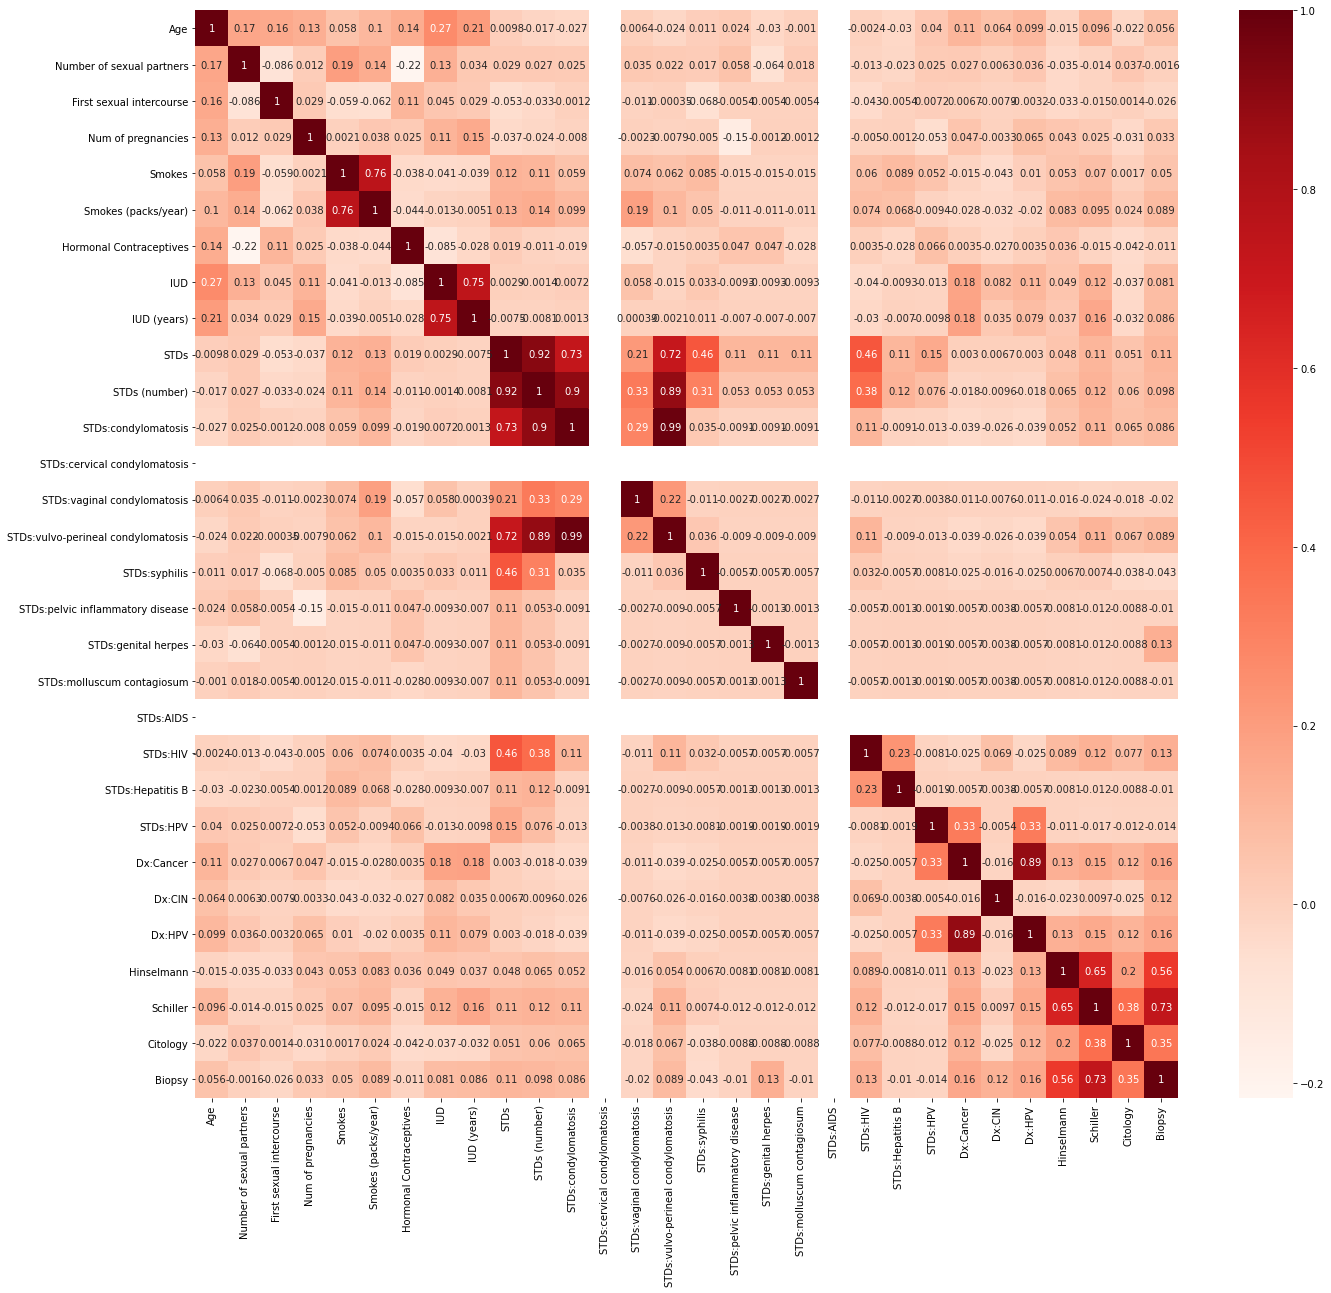

In [7]:
df = pd.read_excel("datos.xlsx")
pt.figure(figsize=(22,20))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=pt.cm.Reds)
pt.show()

### Eliminar variables con correlacion menor a 0.15 con la variable objetivo

In [9]:
corr = df.corr()["Dx:Cancer"].sort_values(ascending=False)[1:]
abs_corr = abs(corr)
relevant_features = abs_corr[abs_corr>0.15]
print(relevant_features)

Dx:HPV         0.886160
STDs:HPV       0.329754
IUD (years)    0.181490
IUD            0.177807
Biopsy         0.160775
Schiller       0.154299
Name: Dx:Cancer, dtype: float64


In [10]:
variables = list(relevant_features.index)
variables.append("Dx:Cancer")
columns = list(df.columns.values)
for i in columns:
    if i not in variables:
        df = df.drop(i, 1)
display(df)

,IUD,IUD (years),STDs:HPV,Dx:Cancer,Dx:HPV,Schiller,Biopsy
0,0,0.0,0,0,0,0,0
1,0,0.0,0,0,0,0,0
2,0,0.0,0,0,0,0,0
3,0,0.0,0,1,1,0,0
4,0,0.0,0,0,0,0,0
...,...,...,...,...,...,...,...
746,0,0.0,0,0,0,0,0
747,0,0.0,0,0,0,0,0
748,0,0.0,0,0,0,0,0
749,0,0.0,0,0,0,0,0


In [11]:
num_evaluaciones = 20

# RANDOM FOREST
f1_score = 0.0
auc_score = 0.0
confusion_matrix = np.zeros((2, 2))
classification_report = {'0': {'precision': 0.0, 'recall': 0.0, 'f1-score':0.0}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score':0.0}}
for i in range(num_evaluaciones):
    f1_score += evaluar_todo_el_set_de_datos('RandomForest', df, 0.3, 'f1-score')
    auc_score += evaluar_todo_el_set_de_datos('RandomForest', df, 0.3, 'auc_score')
    confusion_matrix += evaluar_todo_el_set_de_datos('RandomForest', df, 0.3, 'confusion_matrix')
    report = evaluar_todo_el_set_de_datos('RandomForest', df, 0.3, 'classification_report')
    classification_report['0']['precision'] += report['0']['precision']
    classification_report['0']['recall'] += report['0']['recall']
    classification_report['0']['f1-score'] += report['0']['f1-score']
    classification_report['1']['precision'] += report['1']['precision']
    classification_report['1']['recall'] += report['1']['recall']
    classification_report['1']['f1-score'] += report['1']['f1-score']
f1_score /= num_evaluaciones
auc_score /= num_evaluaciones
confusion_matrix /= num_evaluaciones
classification_report['0']['precision'] /= num_evaluaciones
classification_report['0']['recall'] /= num_evaluaciones
classification_report['0']['f1-score'] /= num_evaluaciones
classification_report['1']['precision'] /= num_evaluaciones
classification_report['1']['recall'] /= num_evaluaciones
classification_report['1']['f1-score'] /= num_evaluaciones
print("RANDOM FOREST: ")
print("Media de f1 score: " + str(f1_score))
print("Media de auc score: " + str(auc_score))
print("Media de confusion matrix: " + str(confusion_matrix))
print("Media de classification report: " + str(classification_report))
print(" --------------------------------------------")

RANDOM FOREST: 
Media de f1 score: 0.8266380841380843
Media de auc score: 0.9954316799773814
Media de confusion matrix: [[219.8    0.5 ]
 [  1.15   4.55]]
Media de classification report: {'0': {'precision': 0.9963869742645397, 'recall': 0.995474834389376, 'f1-score': 0.995915013454683}, '1': {'precision': 0.8290873015873016, 'recall': 0.8515873015873016, 'f1-score': 0.8183881477999124}}
 --------------------------------------------
